# Inter-epoch ViT interpretability
- Modified codes from: https://github.com/hila-chefer/Transformer-Explainability
- Visualize Inter-epoch ViT Interpretability

### Import Modules

In [1]:
import numpy as np
import pandas as pd
import os
import cv2
from tqdm import tqdm
import matplotlib.pyplot as plt

import PIL
from PIL import Image

import torch
import torchvision.transforms as transforms
import torch.nn as nn
from torch.utils.data import Dataset
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.patches as patches


In [2]:
from ViT.ViT_Seq import sleepxvit_inter_epoch
from ViT.Seq_explanation_generator import LRP as inter_LRP

In [3]:
IMG_PATH = "/home/hjlee/shhs1/SHHS1_duplicated_IMG/"

### Prepare GPU & Trained Intra- Inter-epoch ViT

In [4]:
os.environ["CUDA_VISIBLE_DEVICES"]= "2"
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [5]:
inter_model_path = '../shhs1/ckpt/Inter-10-SHHS1-2024-06-25.pth'
inter_model = sleepxvit_inter_epoch(pretrained=True, checkpoint_path = inter_model_path).cuda()
inter_model.eval()
inter_attribution_generator = inter_LRP(inter_model)

### Load Test Dataset

In [15]:
test_label_path = "../shhs1/shhs1_test_label.txt"
IMG_PATH = "/home/hjlee/shhs1/SHHS1_duplicated_IMG/"
os.path.exists(test_label_path)

True

### Load by patients

In [20]:
# read test_labels
df_file_list = pd.read_csv(test_label_path, header=None)
files = df_file_list[0].tolist()

In [21]:
df_file_list

,0,1
0,shhs1-200002.edf_done/0001.png,2
1,shhs1-200002.edf_done/0002.png,2
2,shhs1-200002.edf_done/0003.png,2
3,shhs1-200002.edf_done/0004.png,2
4,shhs1-200002.edf_done/0005.png,2
...,...,...
1654170,shhs1-205462.edf_done/1049.png,0
1654171,shhs1-205462.edf_done/1050.png,0
1654172,shhs1-205462.edf_done/1051.png,0
1654173,shhs1-205462.edf_done/1052.png,0


In [22]:
# create patient_dict
patient_dict = {} # number of vectors that is from the same patient
prev_patient = None

for file in files:
    patient = file.split('/')[0]
    if patient == prev_patient:
        patient_dict[patient] += 1
    else:
        patient_dict[patient] = 1
    prev_patient = patient

### Transformer Explainability code for Inter-epoch ViT

In [24]:
def inter_generate_attributions(image, num_seq, pred_index):
    attributions = []

    for idx in range(num_seq):
        transformer_attribution = inter_attribution_generator.generate_LRP(image.unsqueeze(0).cuda(), method="transformer_attribution", index=pred_index[idx], seq_idx=idx).detach()
        transformer_attribution = transformer_attribution.squeeze()

        # mask mine
        transformer_attribution[idx] = float('-inf')
            
        # second smallest is the smallest value among attributions
        values, indices = torch.topk(transformer_attribution, k=2, largest=False)
        second_smallest_value = values[1].item()
        
        # min-max normalize across each token
        # min_value to be 0 and max_value to be 1
        transformer_attribution = (transformer_attribution - second_smallest_value) / (transformer_attribution.max() - second_smallest_value)
        
        transformer_attribution = transformer_attribution.data.cpu().numpy()
        # set mine attention as 1
        transformer_attribution[idx] = 1
        attributions.append(transformer_attribution)

    # Normalize
    # attributions = (attributions - np.min(attributions)) / (np.max(attributions) - np.min(attributions))
    # print(attributions)
    return attributions

In [46]:
def sliding_windows_attributions(patient_vector, num_seq, batch_size, length, model, y_label, device):
    
    final_attributions = [[] for _ in range(length)]
    final_softmax = [[] for _ in range(length)]
    
    # sum softmax value to the final_agg
    final_agg = [torch.tensor([0, 0, 0, 0, 0], dtype=torch.float32, device=device) for _ in range(length)]
    final_pred = [] # final predictions, length to be 29 (sliding window)
    final_lbl = [] # final labels, length to be 29 for each list (sliding window)
    y_pred = [] # final predictions per epoch
    seq_pred = [[] for _ in range(length)]
    current_seq = [] # container for current_seq
    
    final_seq = num_seq * 2 - 1
    vector_num  = length - num_seq + 1
    
    
    # get the vectors' softmax value by batch
    print("============Get Softmax============")
    for i in tqdm(range(vector_num)):
        current_seq.append(patient_vector[i:i+num_seq]) # stack vectors in current_seq
        
        if (i+1) % batch_size == 0:
            batch_seq = torch.stack(current_seq).to(device)
            current_seq = [] # flush
            output = model(batch_seq) # get the final logit

            for k in range(batch_size):
                temp_pred = []
                for j in range(num_seq):
                    final_softmax[k + j + i - (batch_size-1)].append(torch.softmax(output[j][k], dim=0))
                    final_agg[k + j + i - (batch_size-1)].add_(torch.softmax(output[j][k], dim=0))
                    soft_val = torch.softmax(output[j][k], dim=0)
                    _, predict = soft_val.max(dim=0)
                    temp_pred.append(predict.item())
                for p in range(k + i - (batch_size-1), k + i - (batch_size-1) + num_seq):
                    seq_pred[p].append(temp_pred)
                    
    
    # for remainder
    if len(current_seq) != 0:
        batch_seq = torch.stack(current_seq).to(device)
        output_2 = model(batch_seq)

        new_i = batch_size * ((length - num_seq + 1)//batch_size)

        for k in range(output_2[0].shape[0]):  # batch
            temp_pred = []
            for j in range(num_seq):  # sequence length
                final_agg[k + j + new_i].add_(torch.softmax(output_2[j][k], dim=0))
                final_softmax[k + j + new_i].append(torch.softmax(output_2[j][k], dim=0))
                # get prediction by sequence
                soft_val = torch.softmax(output_2[j][k], dim=0)
                _, predict = soft_val.max(dim=0)
                temp_pred.append(predict.item())
            for p in range(k + new_i, k + new_i + num_seq):
                seq_pred[p].append(temp_pred)
                
    # Now I have final_agg, from this I guess the each of the labeling and save it to y_pred
    for i in range(len(final_agg)):
        _, pred = final_agg[i].max(dim=0)
        y_pred.append(pred.item())
            
    # create final_pred and final_label
    for i in range(length):
        if i < num_seq:
            final_pred.append(y_pred[0:num_seq+i])
            final_lbl.append(y_label[0:num_seq+i])
        elif i > length - num_seq: # 992th ~ 1007th
            final_pred.append(y_pred[i-num_seq+1:length])
            final_lbl.append(y_label[i-num_seq+1:length])
        else:
            final_pred.append(y_pred[i-num_seq+1:num_seq+i])
            final_lbl.append(y_label[i-num_seq+1:num_seq+i])
            
    # Now I have y_pred, use this to get the final_attribution
    print("============Create attributions============")
    for i in tqdm(range(vector_num)):
        current_seq = patient_vector[i:i+num_seq]
        current_pred = y_pred[i:i+num_seq]
        attributions = inter_generate_attributions(current_seq, num_seq, current_pred)
        for j in range(num_seq):
            final_attributions[i+j].append(attributions[j])
    
    return seq_pred, final_pred, final_lbl, final_attributions, final_softmax, y_pred

In [47]:
VECTOR_PATH = "/home/hjlee/shhs1/shhs1-trained/vectors/"

In [48]:
def intra_inter_attributions(patient, length, num_seq):
    
    temp = []
    lbl = []
    epoch_imgs = []
    epoch_preds = []
    epoch_attributions = []
    final_epoch_imgs = []
    final_epoch_preds = []
    final_epoch_attributions = []
    final_seq = num_seq * 2 - 1
    
    patient_epoch = df_file_list[df_file_list[0].str.startswith(patient)]
    sorted_epoch = patient_epoch.sort_values(by=0)
    # print(sorted_epoch)
    
    print("============Create Epoch Attributions============")
    for index, row in tqdm(sorted_epoch.iterrows(), total=len(sorted_epoch)):
        vector_np = torch.from_numpy(np.load(os.path.join(VECTOR_PATH, row[0][:-4] + ".npy")).astype(np.float32))
        # img_path = os.path.join(IMG_PATH, row[0])
        # print(img_path)
        # print(os.path.exists(img_path))
        # epoch_img = torch.from_numpy(transform(img_path))
        # epoch_output = intra_model(epoch_img.unsqueeze(0).cuda())
        # epoch_pred = get_predictions(epoch_output)
        # epoch_attribution = intra_generate_attributions(epoch_img)
        
        # epoch_imgs.append(epoch_img)
        # epoch_preds.append(epoch_pred)
        # epoch_attributions.append(epoch_attribution)
            
        temp.append(vector_np)
        lbl.append(row[1])
        
    patient_vector = torch.stack(temp)
    seq_pred, final_pred, final_lbl, final_attributions, final_softmax, y_pred = sliding_windows_attributions(patient_vector=patient_vector,
                                                                        num_seq=num_seq,
                                                                        batch_size = batch_size,
                                                                        length = length, model = inter_model,
                                                                        y_label = lbl,
                                                                        device=device)
    # create Intra-epoch imgs, preds, attributions for sliding
    # for i in range(length):
    #     if i < num_seq:
    #         final_epoch_imgs.append(epoch_imgs[0:num_seq+i])
    #         final_epoch_preds.append(epoch_preds[0:num_seq+i])
    #         final_epoch_attributions.append(epoch_attributions[0:num_seq+i])
    #     elif i > length - num_seq:
    #         final_epoch_imgs.append(epoch_imgs[i-num_seq+1:length])
    #         final_epoch_preds.append(epoch_preds[i-num_seq+1:length])
    #         final_epoch_attributions.append(epoch_attributions[i-num_seq+1:length])
    #     else:
    #         final_epoch_imgs.append(epoch_imgs[i-num_seq+1:num_seq+i])
    #         final_epoch_preds.append(epoch_preds[i-num_seq+1:num_seq+i])
    #         final_epoch_attributions.append(epoch_attributions[i-num_seq+1:num_seq+i])
    
    # return seq_pred, final_pred, final_lbl, final_attributions, final_softmax, y_pred, final_epoch_imgs, final_epoch_preds, final_epoch_attributions
    return seq_pred, final_pred, final_lbl, final_attributions, final_softmax, y_pred

In [57]:
def inter_explainability(seq_pred, final_pred, final_lbl,
                        final_attributions, final_softmax, y_pred, num_seq):
                        # final_epoch_imgs, final_epoch_preds, final_epoch_attributions, patient, length):
    
    # get aggregated predictions for current epoch
    labels_map = {0:'W', 1:'N1', 2:'N2', 3:'N3', 4:'R'}
    final_seq = num_seq * 2 - 1
    
    # for epoch in tqdm(range(687, length)):
    for epoch in tqdm(range(len(final_pred))): # length
        # epoch_img = final_epoch_imgs[epoch]
        # epoch_preds = final_epoch_preds[epoch]
        # epoch_attributions = final_epoch_attributions[epoch]
        lbls = final_lbl[epoch] # current and neighboring labels|
        
        labels = []
        for l in lbls:
            labels.append(labels_map[l])
            
        # print(len(epoch_img), len(epoch_preds), len(epoch_attributions), len(labels))
        
        # if epoch < num_seq:
        #     index = range(0, num_seq + epoch)
        # elif epoch > length - num_seq:
        #     index = range(epoch-num_seq+1, length)
        # else:
        #     index = range(epoch-num_seq+1, num_seq+epoch)
            
        # print(len(epoch_img), len(epoch_preds), len(epoch_attributions))
        # plot_epoch_images(epoch, index, epoch_img, epoch_attributions, epoch_preds, labels, 5, patient)
        
        preds = final_pred[epoch] # predictions vector
        attributions = final_attributions[epoch] # attributions vector
        softvals = final_softmax[epoch] # current and neighboring softmax values
        pred_idx = y_pred[epoch]

        rolled_attributions = [[0 for _ in range(num_seq * 2 - 1)] for _ in range(num_seq)]

        for i in range(len(attributions)):
            for j in range(i, i+num_seq):
                rolled_attributions[i][j] = attributions[i][j-i]

        agg = []
        total = 0
        
        for i in range(len(softvals)):
            total += softvals[i][pred_idx].item()

        weight = [(softmax[pred_idx] / total).data.cpu().item() for softmax in softvals]
        weighted_attributions = []
        for i in range(len(weight)):
            weighted_attributions.append([weight[i] * x for x in rolled_attributions[i]])
        
        
        # add up the weighted attributions
        ready_attributions = [sum(x) for x in zip(*weighted_attributions)]
        
        # mask self-attributions as -inf
        if epoch < num_seq-1:
            ready_attributions[epoch] = float('-inf')
        else:
            ready_attributions[len(ready_attributions)//2] = float('-inf')
            
        # min-max normalization
        sorted_list = sorted(ready_attributions)
    
        min_val = sorted_list[1] # get the second smallest value
        max_val = max(ready_attributions)
        normalized_attributions = [(x - min_val) / (max_val - min_val) for x in ready_attributions]
        
        # re-assign 0 for the self-attributions
        if epoch < num_seq-1:
            normalized_attributions[epoch] = 0
        else:
            normalized_attributions[len(ready_attributions)//2] = 0
            
        # Create a figure and axis object
        fig, axs = plt.subplots(2, 1, figsize=(7, 7))
        
        # Plot the rolled_attributions
        cmap = plt.cm.get_cmap('hot_r')
        im = axs[0].imshow([normalized_attributions], cmap=cmap, aspect='auto')
        axs[0].set_aspect('equal')
        cbar1 = fig.colorbar(im, ax=axs[0], shrink=0.5)
        axs[0].set_title(f'Epoch {epoch} | Prediction: {labels_map[pred_idx]}', fontsize = 10)

        # Set labels
        axs[0].set_xlabel('GT Labels')
        
        # Set ticks as ground truth
        axs[0].set_xticks(np.arange(len(lbls)))
        axs[0].set_xticklabels(labels)
        axs[0].set_yticks([])
        
        # Tick color
        tick_colors = ['red' if pred != label else 'black' for pred, label in zip(preds, lbls)]
        for tick, color in zip(axs[0].get_xticklabels(), tick_colors):
            tick.set_color(color)
        
        # Text color
        for i in range(len(preds)):
            txt = labels_map[preds[i]]
            if epoch < num_seq-1 and i == epoch:
                axs[0].text(i, 0, txt, color="black", ha="center", va="center", weight="bold")
            elif epoch >= num_seq-1 and i == num_seq-1:
                axs[0].text(i, 0, txt, color="black", ha="center", va="center", weight="bold")
            else:
                if normalized_attributions[i] > 0.5:
                    axs[0].text(i, 0, txt, color="white", ha="center", va="center")
                else:
                    axs[0].text(i, 0, txt, color="black", ha="center", va="center")

        # Add borders around each cell
        for i in range(len(preds)):
            if epoch < num_seq-1 and i == epoch:
                rect = patches.Rectangle((i -0.5, -0.5), 1, 1, linewidth=1, edgecolor='black', facecolor='none')
                axs[0].add_patch(rect)
            elif epoch >= num_seq-1 and i == num_seq-1:
                rect = patches.Rectangle((i -0.5, -0.5), 1, 1, linewidth=1, edgecolor='black', facecolor='none')
                axs[0].add_patch(rect)
            else:
                continue
            
        # Show the plot
        # plt.show()
        
        ########################################################################################################
        seq_p = seq_pred[epoch]
        lbl = final_lbl[epoch] # aggregated label (1)

        rolled_attributions = [[0 for _ in range(num_seq * 2 - 1)] for _ in range(len(seq_p))]

        for i in range(len(attributions)):
            for j in range(i, i+num_seq):
                rolled_attributions[i][j] = attributions[i][j-i]
                
        rolled_predictions = [[None for _ in range(num_seq * 2 - 1)] for _ in range(len(seq_p))]

        for i in range(len(seq_p)):
            for j in range(i, i+num_seq):
                # make the target sequence as 0
                if epoch < num_seq-1:
                    rolled_attributions[i][epoch] = 0
                else:
                    rolled_attributions[i][num_seq-1] = 0
                rolled_predictions[i][j] = labels_map[seq_p[i][j-i]]
                                
        # Create a figure and axis object
        # fig, ax = plt.subplots(figsize=(10, 8))

        # Plot the rolled_attributions
        cmap = plt.cm.get_cmap('hot_r')
        im = axs[1].imshow(rolled_attributions, cmap=cmap, aspect='auto')
        axs[1].set_aspect('equal')

        # Add colorbar
        cbar1 = fig.colorbar(im, ax=axs[1], shrink=0.5)

        # Calculate predictions and set title
        pred_label = labels_map[pred_idx]
        axs[1].set_title(f'Epoch {epoch} | Prediction: {pred_label}', fontsize = 10)

        # Set labels
        # ax.set_ylabel('Sliding Windows')
        axs[1].set_xlabel('GT Labels')

        # Set ticks
        axs[1].set_xticks(np.arange(len(lbl)))
        axs[1].set_yticks([])
        
        # Tick color
        tick_colors = ['red' if pred != label else 'black' for pred, label in zip(preds, lbls)]
        for tick, color in zip(axs[1].get_xticklabels(), tick_colors):
            tick.set_color(color)
        
        labels = []
        for l in lbls:
            labels.append(labels_map[l])
        axs[1].set_xticklabels(labels)


        # Put predictions labels on the cell        
        for i in range(len(rolled_predictions)):
            for j, txt in enumerate(rolled_predictions[i]):
                # ax.text(j, i, txt, color="white", ha="center", va="center")
                if epoch < num_seq-1 and j == epoch:
                    axs[1].text(j, i, txt, color="black", ha="center", va="center")
                elif epoch >= num_seq-1 and j == num_seq-1:
                    axs[1].text(j, i, txt, color="black", ha="center", va="center")
                else:
                    if rolled_attributions[i][j] > 0.5:
                        axs[1].text(j, i, txt, color="white", ha="center", va="center")
                    else:
                        axs[1].text(j, i, txt, color="black", ha="center", va="center")
        
        # Add borders around each cell
        for i in range(len(rolled_attributions)):
            for j in range(len(rolled_attributions[i])):
                if epoch < num_seq-1 and j == epoch:
                    rect = patches.Rectangle((j - 0.5, i - 0.5), 1, 1, linewidth=1, edgecolor='black', facecolor='none')
                    axs[1].add_patch(rect)
                elif epoch >= num_seq-1 and j == num_seq-1:
                    rect = patches.Rectangle((j - 0.5, i - 0.5), 1, 1, linewidth=1, edgecolor='black', facecolor='none')
                    axs[1].add_patch(rect)
                else:
                    continue
        
        str_epoch = "0" * (4 - len(str(epoch))) + str(epoch)
        # Show the plot
        # save_path = f"/tf/data_AIoT1/psg_image_codes/explainability_code/Explainability-Images/{patient}/inter_" + str_epoch + ".png"
        # plt.savefig(save_path, bbox_inches='tight')
        plt.show()

### Visualize single patient

In [50]:
use_thresholding = False
batch_size = 512
num_seq = 10

In [51]:
ex_patient = 'shhs1-200002.edf_done'

In [52]:
ex_length = patient_dict[ex_patient]
ex_length

1079

In [54]:
seq_pred, final_pred, final_lbl, final_attributions, final_softmax, y_pred = intra_inter_attributions(ex_patient, ex_length, num_seq)

============Create Epoch Attributions============


100%|██████████| 1079/1079 [00:00<00:00, 2086.73it/s]


============Get Softmax============


100%|██████████| 1070/1070 [00:00<00:00, 1191.21it/s]


============Create attributions============


100%|██████████| 1070/1070 [16:55<00:00,  1.05it/s]


In [1]:
# inter_intra_explainability(seq_pred, final_pred, final_lbl,
#                           final_attributions, final_softmax, y_pred, num_seq,
#                           final_epoch_imgs, final_epoch_preds, final_epoch_attributions, ex_patient, ex_length)

  0%|          | 0/1079 [00:00<?, ?it/s]/tmp/ipykernel_3397131/2480865913.py:81: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('hot_r')
/tmp/ipykernel_3397131/2480865913.py:152: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('hot_r')


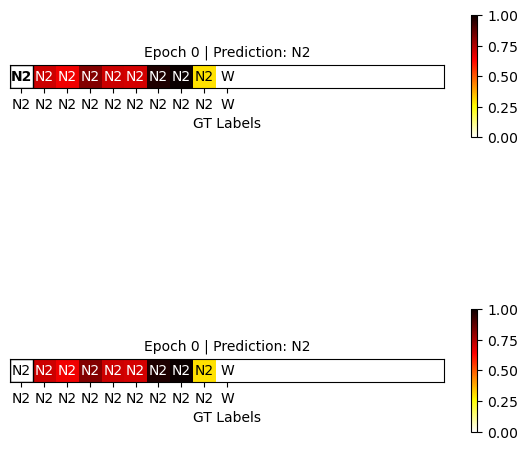

  0%|          | 1/1079 [00:00<12:31,  1.43it/s]

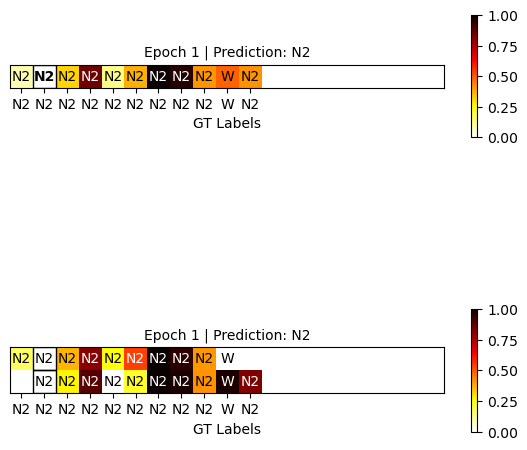

  0%|          | 2/1079 [00:00<08:18,  2.16it/s]

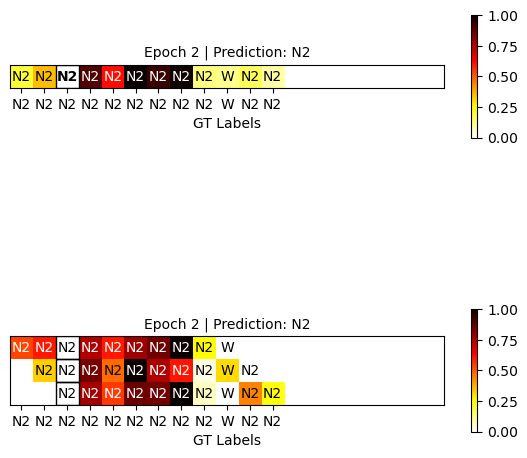

  0%|          | 3/1079 [00:01<07:08,  2.51it/s]

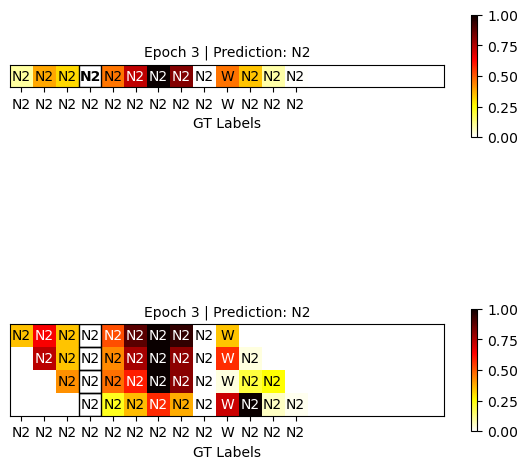

  0%|          | 4/1079 [00:02<09:56,  1.80it/s]

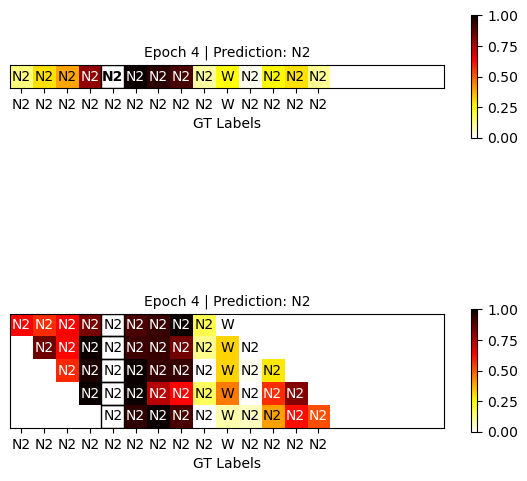

  0%|          | 5/1079 [00:02<08:41,  2.06it/s]

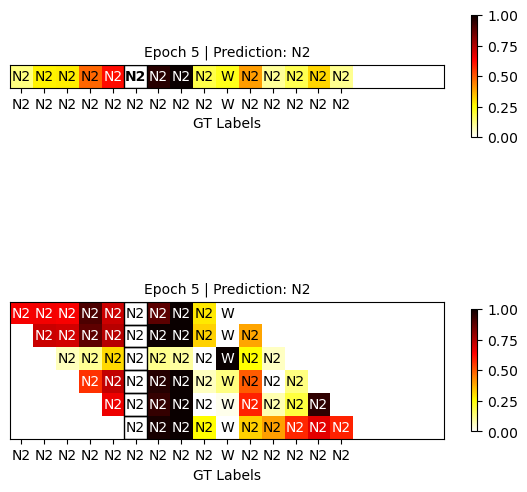

  1%|          | 6/1079 [00:02<08:05,  2.21it/s]

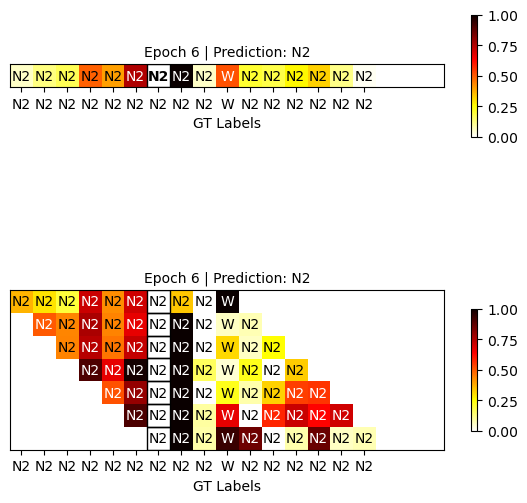

  1%|          | 7/1079 [00:03<07:49,  2.28it/s]

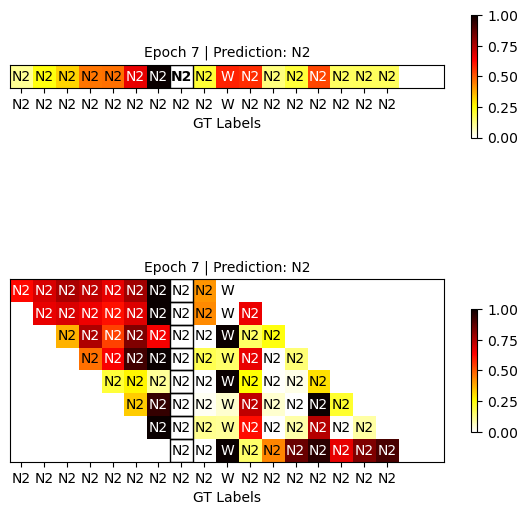

  1%|          | 8/1079 [00:03<07:46,  2.30it/s]

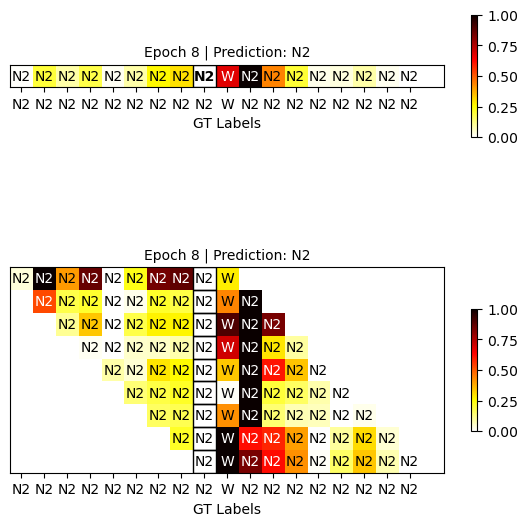

  1%|          | 9/1079 [00:04<09:15,  1.93it/s]

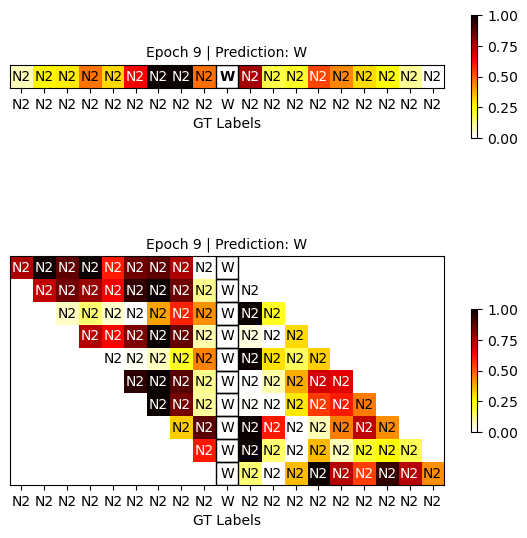

  1%|          | 10/1079 [00:04<09:06,  1.96it/s]

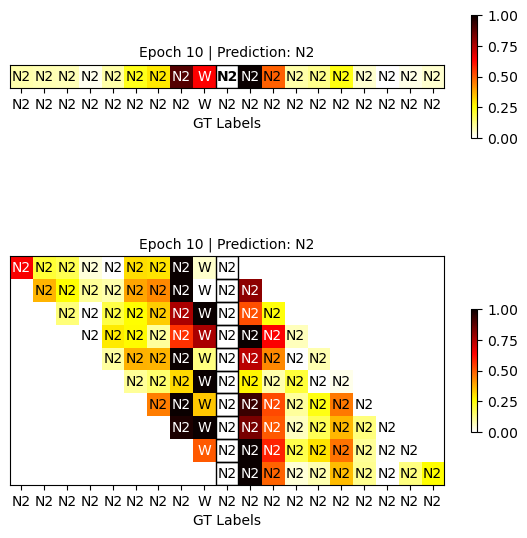

  1%|          | 11/1079 [00:05<08:53,  2.00it/s]

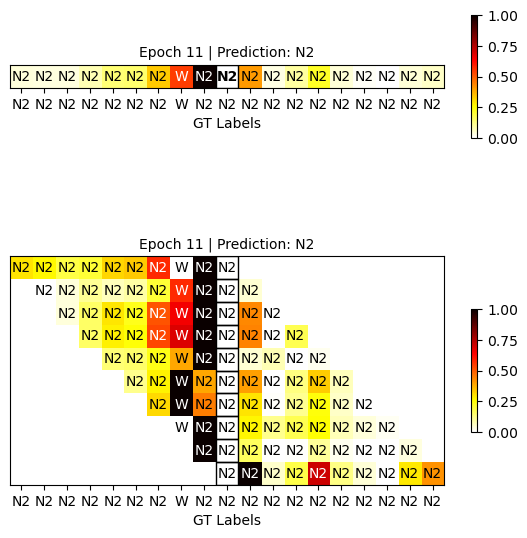

  1%|          | 12/1079 [00:05<08:43,  2.04it/s]

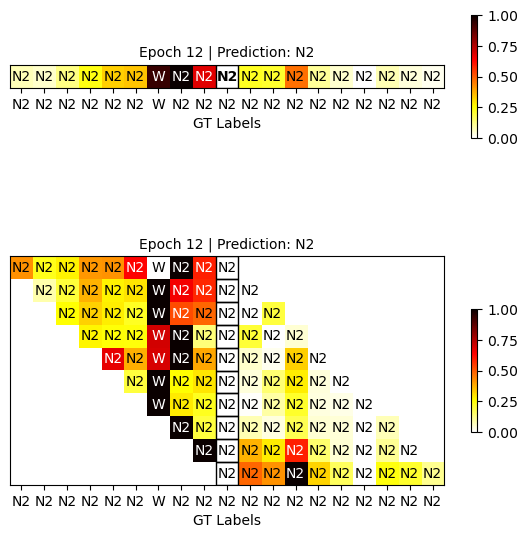

  1%|          | 13/1079 [00:06<10:02,  1.77it/s]

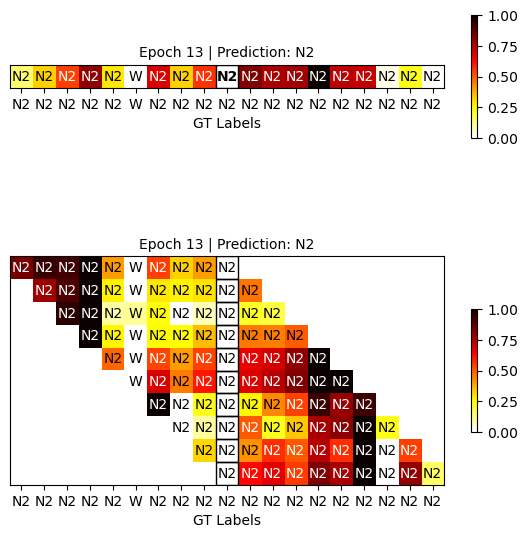

  1%|▏         | 14/1079 [00:07<09:31,  1.86it/s]

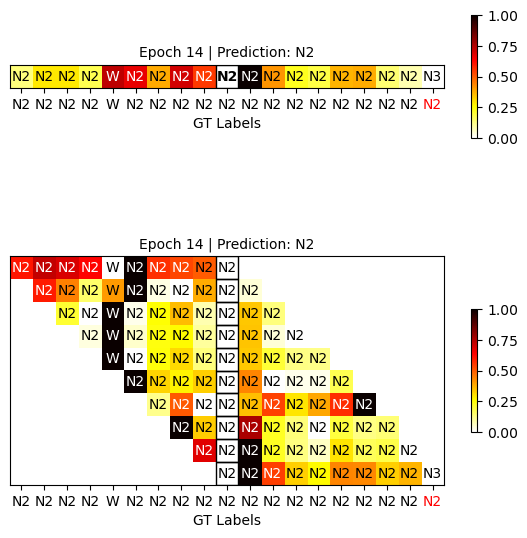

  1%|▏         | 15/1079 [00:07<09:10,  1.93it/s]

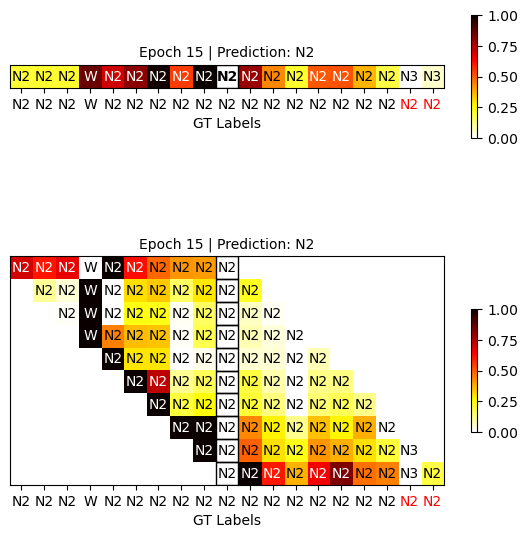

  1%|▏         | 16/1079 [00:07<08:55,  1.98it/s]

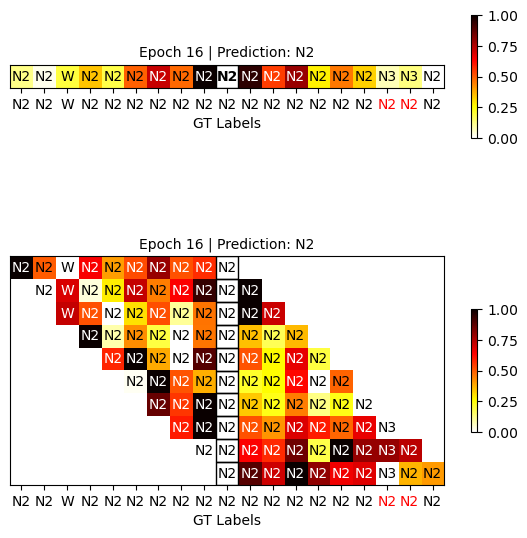

  2%|▏         | 17/1079 [00:08<08:44,  2.03it/s]

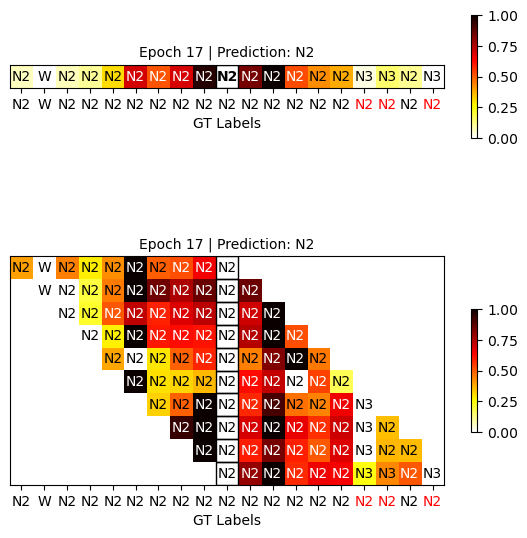

  2%|▏         | 18/1079 [00:09<09:59,  1.77it/s]

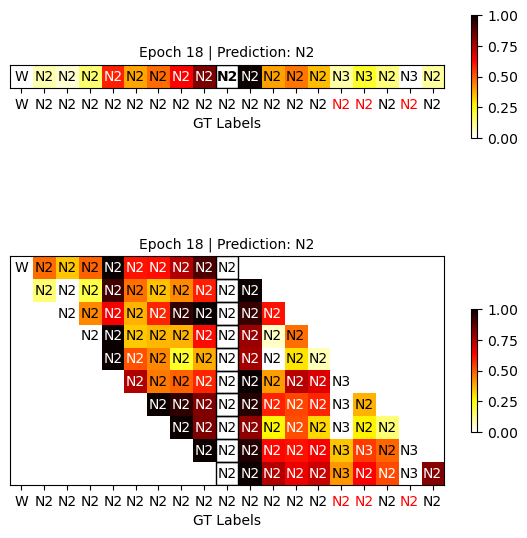

  2%|▏         | 19/1079 [00:09<09:30,  1.86it/s]

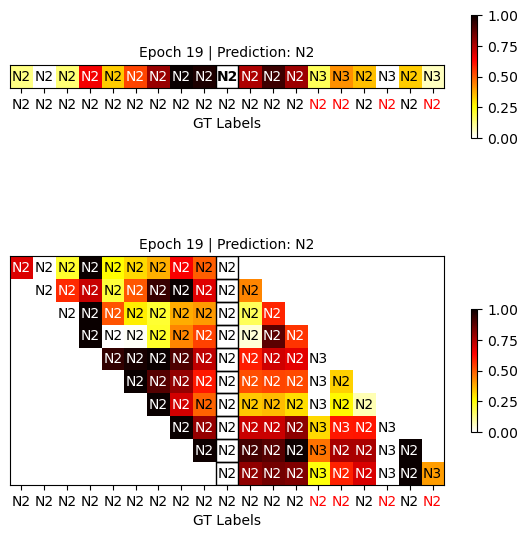

  2%|▏         | 20/1079 [00:10<09:08,  1.93it/s]

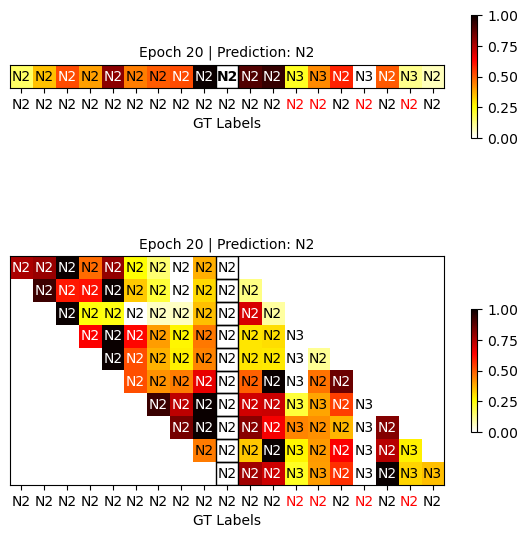

  2%|▏         | 21/1079 [00:10<08:52,  1.99it/s]

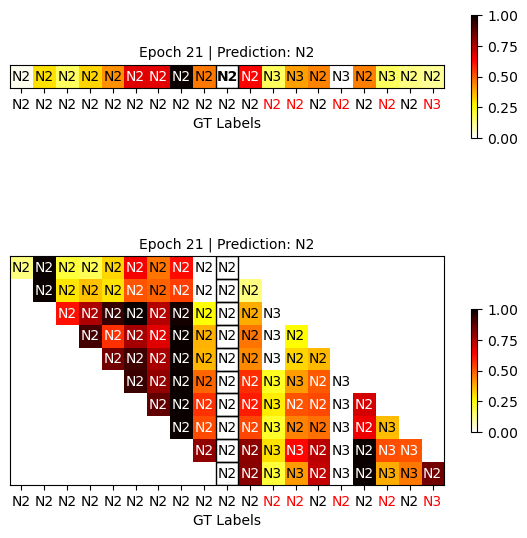

  2%|▏         | 22/1079 [00:11<10:07,  1.74it/s]

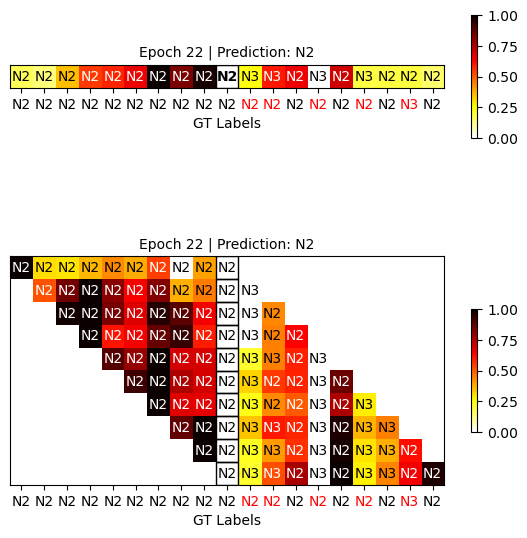

  2%|▏         | 23/1079 [00:11<09:34,  1.84it/s]

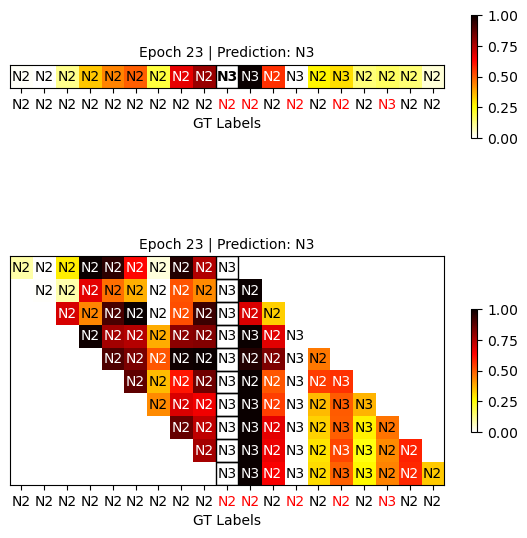

  2%|▏         | 24/1079 [00:12<09:11,  1.91it/s]

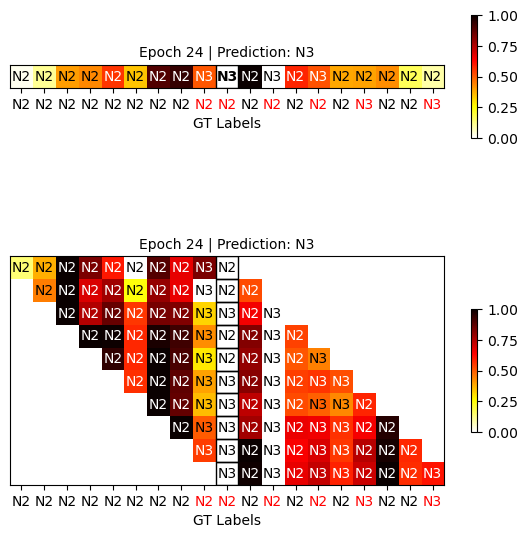

  2%|▏         | 25/1079 [00:12<08:56,  1.96it/s]

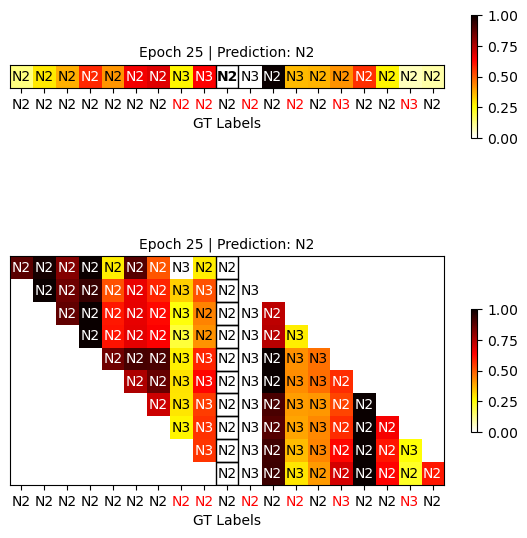

  2%|▏         | 26/1079 [00:13<10:29,  1.67it/s]

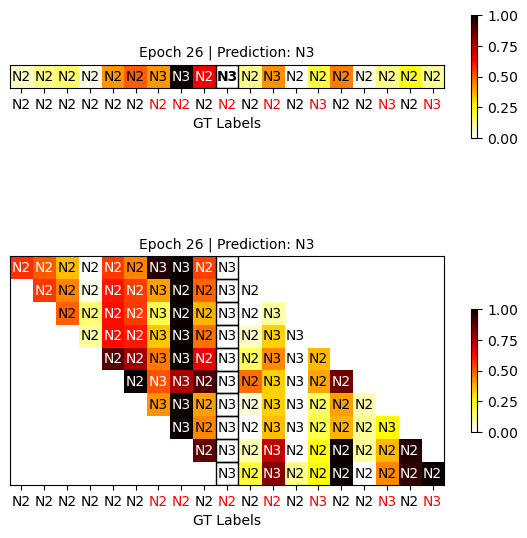

  3%|▎         | 27/1079 [00:14<09:50,  1.78it/s]

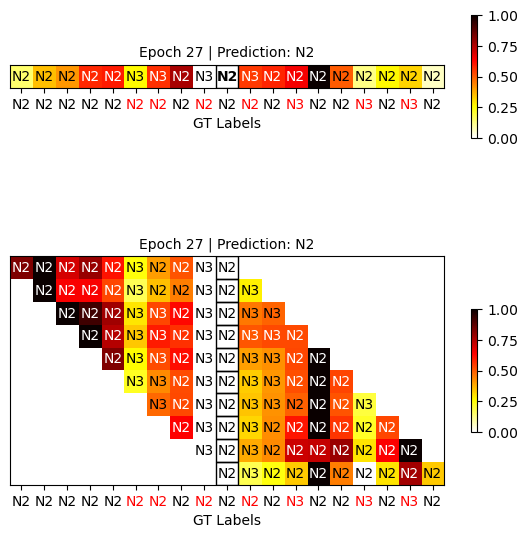

  3%|▎         | 28/1079 [00:14<09:23,  1.87it/s]

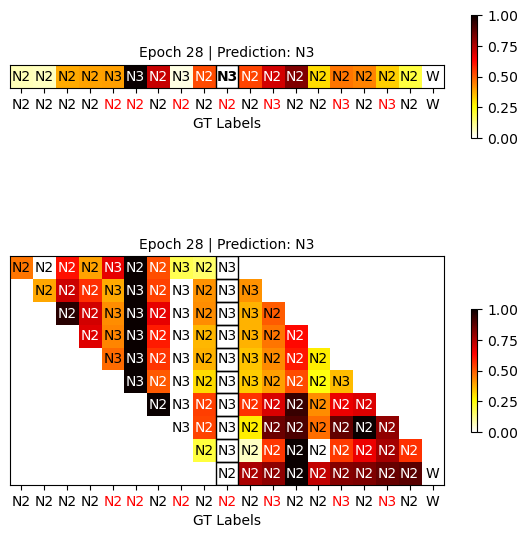

  3%|▎         | 29/1079 [00:15<09:03,  1.93it/s]

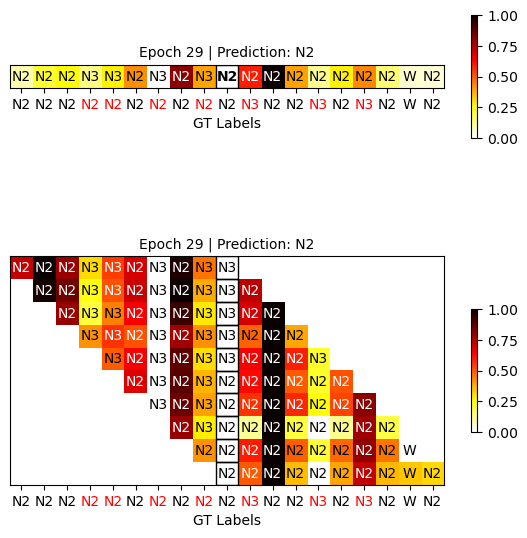

  3%|▎         | 30/1079 [00:15<10:16,  1.70it/s]

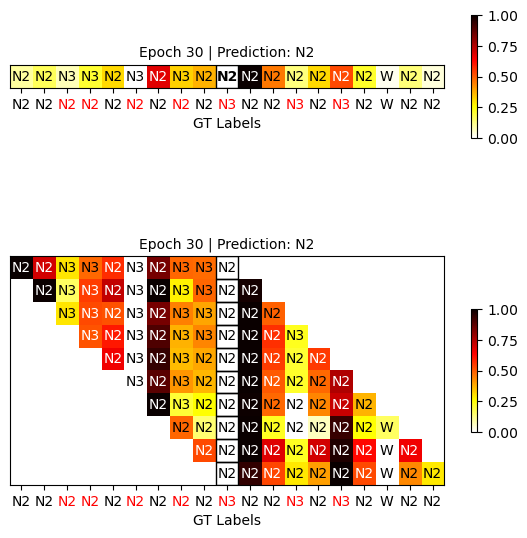

  3%|▎         | 31/1079 [00:16<09:41,  1.80it/s]

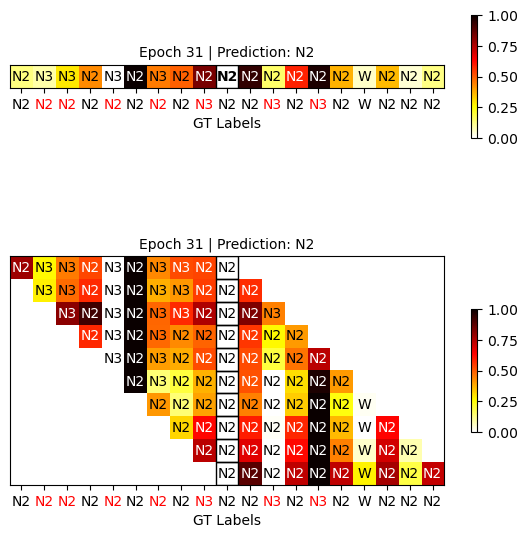

  3%|▎         | 32/1079 [00:17<09:18,  1.87it/s]


KeyboardInterrupt: 

In [58]:
inter_explainability(seq_pred, final_pred, final_lbl, final_attributions, final_softmax, y_pred, num_seq)